In [3]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from random import randint
import time
from ships_loader import create_imdb, ships_dataset
import signal, os
import numpy as np
import cv2
import matplotlib.pyplot as plt 
from model import VGG, ResNet

device= torch.device("cuda")
#device= torch.device("cpu")
print(device)

import sys
sys.argv = ['base.py', '--d']

parser = argparse.ArgumentParser()


parser.add_argument('--r', dest='resume',
                      help='resume checkpoint or not',
                      action='store_true')

parser.add_argument('--d', dest='demo',
                      help='demo on some test set',
                      action='store_true')

parser.add_argument('--e', dest='eval',
                      help='evaluate on full test set',
                      action='store_true')


parser.add_argument('--t', dest='train',
                      help='train on train set',
                      action='store_true')

args = parser.parse_args()




cuda


In [4]:
my_lr=0.002 
net = VGG()
#net = ResNet()
start_epoch = 1
start_step = 1

if args.resume or args.demo or args.eval:
    checkpoint = torch.load("../../models/base/vgg_base_model.pth")
    start_epoch = checkpoint['epoch']
    net.load_state_dict(checkpoint['model'])
    my_lr = checkpoint['lr']
    start_step = checkpoint['step']
    lost = checkpoint['lost']
    error = checkpoint['error']
    print(lost)       

print(net)

net = net.to(device)

criterion = nn.CrossEntropyLoss()


[0.044501662254333496, 0.18062259699448502, 0.1933062425071511, 0.18930743817715429, 0.18791756980690283]
VGG(
  (conv1a): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1a): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2a): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2b): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3a): Conv2d(128, 256, kernel_size=

In [5]:
def get_error( scores , labels ):

    bs=scores.size(0)
    predicted_labels = scores.argmax(dim=1)
    indicator = (predicted_labels == labels)
    num_matches=indicator.sum()
    
    return 1-num_matches.float()/bs, num_matches

file_dir = ""
image_dir = ""
if args.demo or args.eval:
    file_dir = "../../dataset/input/test_ship_segmentations.csv"
    image_dir = "../../dataset/test"
elif args.train or args.resume:
    file_dir = "../../dataset/input/train_ship_segmentations.csv"
    image_dir = "../../dataset/train"
else:
    print("Please provide input data info")
    exit()

imdb = create_imdb(file_dir, image_dir)
dataset = ships_dataset(imdb)
bs = 4

39825


base.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ships_loader import create_imdb, ships_dataset


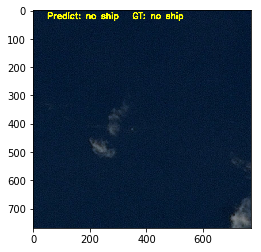

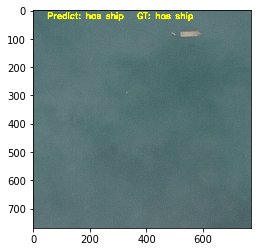

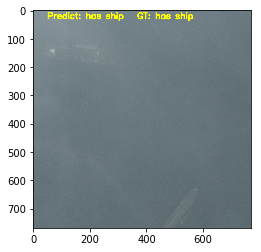

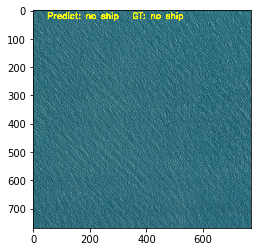

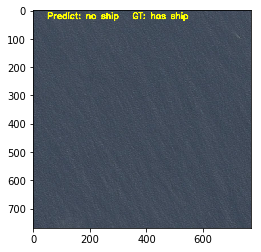

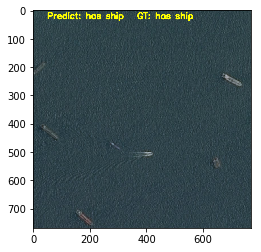

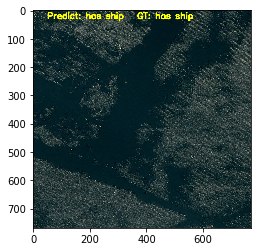

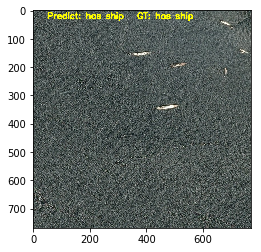

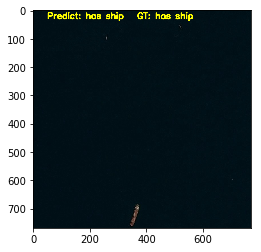

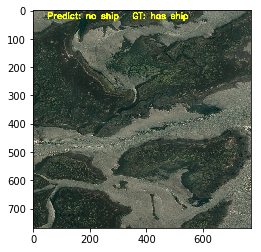

In [6]:
if args.demo:
    dataloader = torch.utils.data.DataLoader(dataset, batch_size = 1, shuffle=True)
    data_iter = iter(dataloader)
    for i in range(10):
        inputs, labels, image_files = next(data_iter)
        inputs=inputs.to(device)
        scores=net( inputs )
        prob = F.softmax(scores)
        im = cv2.imread(image_files[0])
        values, indices = torch.max(prob, 1)
        text = "Predict: " + ("has ship" if indices[0] == 1 else "no ship") + "   GT: " + ("has ship" if labels[0] == 1 else "no ship")
        cv2.putText(im, text, (50, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 255), 3, lineType=cv2.LINE_AA)
        plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
        plt.show()
    exit()

In [10]:
if args.eval:
    dataloader = torch.utils.data.DataLoader(dataset, batch_size = 1, shuffle=True)
    data_iter = iter(dataloader)
    num_matched=0
    num_batches=0
    data_size = len(data_iter)
    for i in range(len(data_iter)):
        inputs, labels, image_files = next(data_iter)
        inputs=inputs.to(device)
        labels = labels.to(device)
        scores = net( inputs )
        #prob = F.softmax(scores)
        
        # compute the error made on this batch and add it to the running error       
        error, matched = get_error( scores.detach() , labels)
        num_matched += matched.item()
        num_batches += 1
        if i % 100 == 0:
            print("(%s/%d)\t: %.4lf%%" % (i, data_size, (num_matched / num_batches) * 100))
    exit()
    

In [1]:
train_size = len(dataset)
step = int(train_size / bs)
print("train size: " + str(train_size))
print("step: " + str(step))

dataloader = torch.utils.data.DataLoader(dataset, batch_size = bs, shuffle=True)
start=time.time()

lost = []
errors = []

NameError: name 'dataset' is not defined

In [2]:
for epoch in range(start_epoch, 20):
    data_iter = iter(dataloader)
    # divide the learning rate by 2 at epoch 10, 14 and 18
    
    # create a new optimizer at the beginning of each epoch: give the current learning rate.   
    optimizer=torch.optim.SGD( net.parameters() , lr=my_lr )
        
    # set the running quatities to zero at the beginning of the epoch
    running_loss=0
    running_error=0
    num_batches=0
 
    for count in range(start_step, step + 1):

        # Set the gradients to zeros
        optimizer.zero_grad()
        
        # create a minibatch       
        minibatch_data, minibatch_label, _ = next(data_iter)
        
        # send them to the gpu
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        inputs = minibatch_data
        # tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # forward the minibatch through the net 
        scores=net( inputs ) 

        # Compute the average of the losses of the data points in the minibatch
        loss =  criterion( scores , minibatch_label) 
        
        # backward pass to compute dL/dU, dL/dV and dL/dW   
        loss.backward()

        # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
        optimizer.step()
        

        # START COMPUTING STATS
        
        # add the loss of this batch to the running loss
        running_loss += loss.detach().item()
        
        # compute the error made on this batch and add it to the running error       
        error, _ = get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1        
    
        if(count % 100 == 0):
            
            # compute stats for the full training set
            total_loss = running_loss/num_batches
            total_error = running_error/num_batches
            elapsed = (time.time()-start)/60

            if int(elapsed) % 10 == 0:
                lost.append(total_loss)
                errors.append(total_error)
                torch.save({
                    'model': net.state_dict(),
                    'epoch': epoch,
                    'step': count,
                    'lr': my_lr,
                    'lost': lost,
                    'error':error
                }, "../../models/base/resnet_base_model.pth")
            

            print('epoch=',epoch, '\t step=', count, '/', step, '\t time=', elapsed,'min','\t lr=', my_lr  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
            #eval_on_test_set() 
            print(' ')
            
    my_lr = my_lr / 2

NameError: name 'start_epoch' is not defined